In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights
from torch import nn

# # Load CIFAR-10 datasets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         shuffle=False)
class_names = ['plane', 'car']
# Just choose the plane and car data
filtered_train_plane_car_only = list(filter(lambda x: x[1] < 2, trainset))
filtered_test_plane_car_only = list(filter(lambda x: x[1] < 2, testset))

trainloader = torch.utils.data.DataLoader(filtered_train_plane_car_only, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(filtered_test_plane_car_only, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


image of automobiles from the test set:


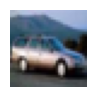

image of airplanes from the test set:


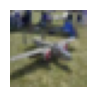

In [3]:
### Visualize Instances

print("image of automobiles from the test set:")

img = filtered_train_plane_car_only[0][0] / 2 + 0.5  # Reverse normalization
img = np.transpose(img.numpy(), (1, 2, 0))
plt.figure(figsize=(1, 1))
plt.imshow(img)
plt.axis('off')
plt.show()

print("image of airplanes from the test set:")

img = filtered_train_plane_car_only[1000][0] / 2 + 0.5  # Reverse normalization
img = np.transpose(img.numpy(), (1, 2, 0))
plt.figure(figsize=(1, 1))

plt.imshow(img)
plt.axis('off')
plt.show()

In [3]:
# Load a pre-trained ResNet-50 model
resnet_cross_entropy = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

num_class = 2


# Freeze the pre-trained layers of ResNet-50
for param in resnet_cross_entropy.parameters():
    param.requires_grad = True

# Add a fully connected layer and Sigmoid Layer to Classifying images
num_features = resnet_cross_entropy.fc.in_features
resnet_cross_entropy.fc = nn.Sequential(
    nn.Linear(num_features, num_class - 1 ),
    nn.Sigmoid()
)

def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        nn.init.zeros_(layer.bias)

resnet_cross_entropy.fc.apply(initialize_weights)

# Turn on Grad for all layers
for param in resnet_cross_entropy.parameters():
    param.requires_grad = True

# for param in resnet.layer4.parameters():
#     param.requires_grad = True

### Define Cross Entropy loss function
criterion = nn.BCELoss()

### Define optimizer
optimizer = torch.optim.Adam(resnet_cross_entropy.parameters(), lr=0.0005)

# Train the model
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_cross_entropy.to(device)

loss_values = []
accuracy_values = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_cross_entropy(inputs)
        outputs = outputs.view(-1)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.float()).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = (100 * correct / total)

    loss_values.append(epoch_loss)
    accuracy_values.append(epoch_accuracy)

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


Epoch 1, Loss: 0.2351, Accuracy: 92.47%
Epoch 2, Loss: 0.0504, Accuracy: 98.38%
Epoch 3, Loss: 0.0252, Accuracy: 99.22%
Epoch 4, Loss: 0.0089, Accuracy: 99.75%
Epoch 5, Loss: 0.0143, Accuracy: 99.49%


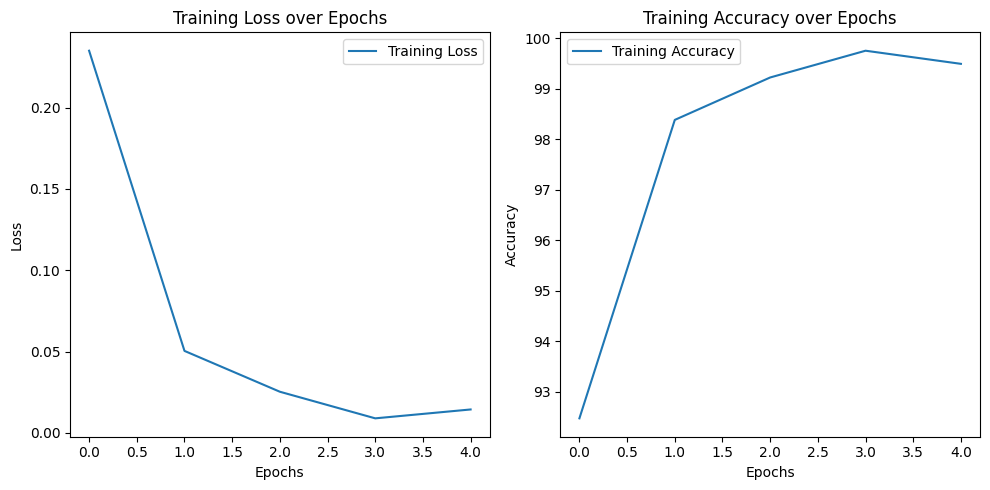

In [4]:
# Visualize loss and accuracy on Training Set
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
### Set the model to evaluation mode
resnet_cross_entropy.eval()
### calculate the number of correct samples
correct = 0
for data in testloader:
    a = resnet_cross_entropy(data[0].to(device))
    if (a > 0.5 and int(data[1])  == 1) or (a < 0.5 and int(data[1])  == 0) :
        correct+= 1

### Calculate the accuracy on Test set

accuracy = correct / len(testloader)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 0.98%


In [23]:
from torch.utils.data import Dataset, DataLoader
import random


triplets = []
for batch in trainloader:
    inputs, labels = batch

    # Split the batch based on class labels (0 and 1)
    class_0_indices = (labels == 0).nonzero().squeeze()
    class_1_indices = (labels == 1).nonzero().squeeze()

    for i in range(len(class_0_indices)):
        b  = list(class_0_indices.clone())
        b.pop(i)
        ### for every sample attach a Similar and dissimilar data
        triplets.append((inputs[class_0_indices[i]], ### anchor data
                         inputs[random.choice(b)], ### positive data
                         inputs[random.choice(class_1_indices)] ### negative data
                        ))


# Create Dataset class for triplets
class TripletDataset(Dataset):
    def __init__(self, triplets, transform=None):
        self.triplets = triplets
        self.transform = transform

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor, positive, negative = self.triplets[idx]

        # Load data for anchor, positive, and negative samples
        # (Assuming data loading logic for anchor, positive, negative)

        # Apply transformations if needed
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

# Assuming 'triplets_list' contains your list of triplets (anchor, positive, negative)

# Create an instance of the custom dataset
custom_dataset = TripletDataset(triplets)

# Define a DataLoader for training
train_loader = DataLoader(custom_dataset, batch_size=32, shuffle=True)


In [24]:
### Utilize Triplet Loss Function for Image Classification
# Define the ResNet-50 model

resnet_triplet_loss = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_features = resnet_triplet_loss.fc.in_features
loss_values = []
# Replace the final fully connected layer with an identity layer to obtain embeddings
resnet_triplet_loss.fc = nn.Identity()

# Define the triplet loss function
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):

        distance_positive = torch.nn.functional.pairwise_distance(anchor, positive)
        distance_negative = torch.nn.functional.pairwise_distance(anchor, negative)
        loss = torch.relu(distance_positive - distance_negative + self.margin)
        return torch.mean(loss)

triplet_loss = TripletLoss()

# Define optimizer
optimizer = torch.optim.Adam(resnet_triplet_loss.parameters(), lr=0.00001)

# Training loop to minimize triplet loss for feature extraction
num_epochs = 5
resnet_triplet_loss.to(device)

for epoch in range(num_epochs):
    resnet_triplet_loss.train()
    running_loss = 0.0

    for batch_idx, (anchor, positive, negative) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        anchor_output = resnet_triplet_loss(anchor.to(device))
        positive_output = resnet_triplet_loss(positive.to(device))
        negative_output = resnet_triplet_loss(negative.to(device))

        # Calculate triplet loss
        loss = triplet_loss(anchor_output, positive_output, negative_output)
        running_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/5], Loss: 2.8263
Epoch [2/5], Loss: 0.9980
Epoch [3/5], Loss: 0.2146
Epoch [4/5], Loss: 0.1078
Epoch [5/5], Loss: 0.0682


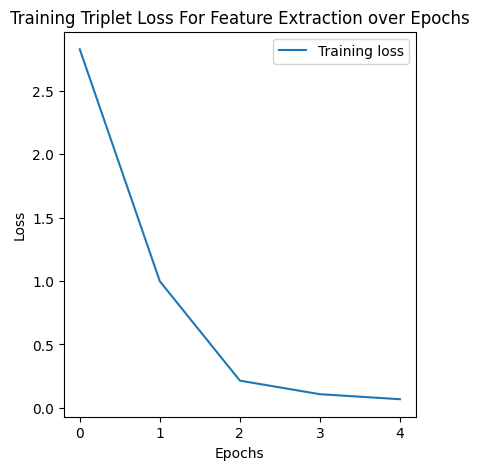

In [25]:
# Visualize loss and accuracy on Training Set for Feature Extraction
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Triplet Loss For Feature Extraction over Epochs')
plt.legend()

In [29]:
### now attach a fully connected layer to our model
num_class = 2
trainloader = torch.utils.data.DataLoader(filtered_train_plane_car_only, batch_size=128, shuffle=True)

# Freeze the pre-trained layers of ResNet-50
for param in resnet_triplet_loss.parameters():
    param.requires_grad = False

# Add a fully connected layer and Sigmoid Layer to Classifying images
resnet_triplet_loss.fc = nn.Sequential(
    nn.Linear(2048, num_class - 1 ),
    nn.Sigmoid()
)

def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        nn.init.zeros_(layer.bias)

resnet_triplet_loss.fc.apply(initialize_weights)


for param in resnet_triplet_loss.fc.parameters():
    param.requires_grad = True

### Define Cross Entropy loss function
criterion = nn.BCELoss()

### Define optimizer
resnet_triplet_loss.to(device)
optimizer = torch.optim.Adam(resnet_triplet_loss.parameters(), lr=0.001)

# Train the model
num_epochs = 200
loss_values = []
accuracy_values = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_triplet_loss(inputs)
        outputs = outputs.view(-1)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.float()).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = (100 * correct / total)

    loss_values.append(epoch_loss)
    accuracy_values.append(epoch_accuracy)
    if epoch%10 == 0 :
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


Epoch 1, Loss: 0.4520, Accuracy: 80.19%
Epoch 11, Loss: 0.2245, Accuracy: 91.62%
Epoch 21, Loss: 0.1939, Accuracy: 92.77%
Epoch 31, Loss: 0.1787, Accuracy: 93.37%
Epoch 41, Loss: 0.1668, Accuracy: 93.92%
Epoch 51, Loss: 0.1596, Accuracy: 94.16%
Epoch 61, Loss: 0.1531, Accuracy: 94.64%
Epoch 71, Loss: 0.1523, Accuracy: 94.67%
Epoch 81, Loss: 0.1409, Accuracy: 95.03%
Epoch 91, Loss: 0.1359, Accuracy: 95.28%
Epoch 101, Loss: 0.1356, Accuracy: 95.10%
Epoch 111, Loss: 0.1293, Accuracy: 95.47%
Epoch 121, Loss: 0.1277, Accuracy: 95.54%
Epoch 131, Loss: 0.1303, Accuracy: 95.23%
Epoch 141, Loss: 0.1221, Accuracy: 95.75%
Epoch 151, Loss: 0.1230, Accuracy: 95.84%
Epoch 161, Loss: 0.1183, Accuracy: 95.87%
Epoch 171, Loss: 0.1190, Accuracy: 96.04%
Epoch 181, Loss: 0.1165, Accuracy: 96.04%
Epoch 191, Loss: 0.1146, Accuracy: 95.96%


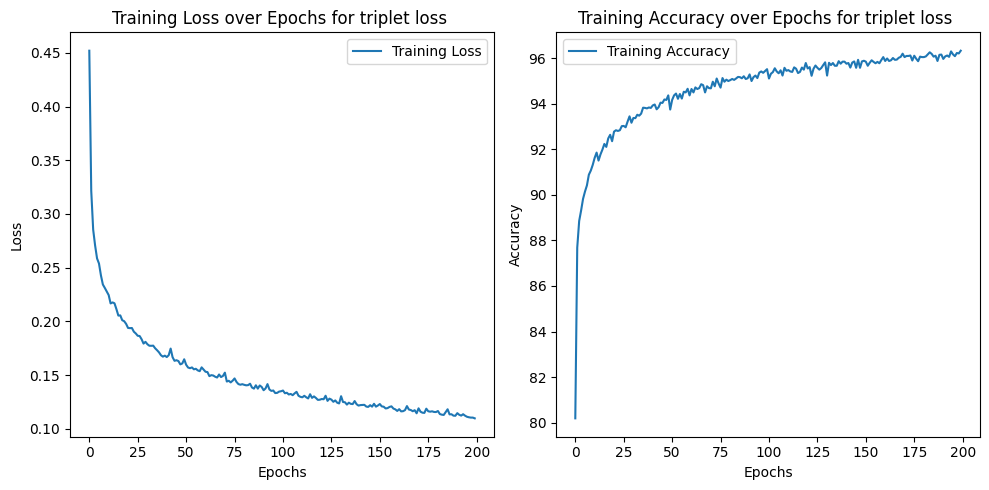

In [31]:
# Visualize loss and accuracy on Training Set for triplet loss
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs for triplet loss ')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs for triplet loss ')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
### Set the model to evaluation mode
resnet_triplet_loss.eval()
### calculate the number of correct samples
correct = 0
for data in testloader:
    a = resnet_triplet_loss(data[0].to(device))
    if (a > 0.5 and int(data[1])  == 1) or (a < 0.5 and int(data[1])  == 0) :
        correct+= 1

### Calculate the accuracy on Test set

accuracy = correct / len(testloader)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 0.90%


In [42]:
num_class = 2
trainloader = torch.utils.data.DataLoader(filtered_train_plane_car_only, batch_size=128, shuffle=True)

### train Simultaneously with tripet loss and BCE loss
resnet_triplet_loss_cross_entropy = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Add a fully connected layer and Sigmoid Layer to Classifying images
resnet_triplet_loss_cross_entropy.fc = nn.Sequential(
    nn.Linear(2048, num_class - 1 ),
    nn.Sigmoid()
)

def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        nn.init.zeros_(layer.bias)

resnet_triplet_loss_cross_entropy.fc.apply(initialize_weights)


# Freeze the pre-trained layers of ResNet-50
for param in resnet_triplet_loss_cross_entropy.parameters():
    param.requires_grad = True


### Define Cross Entropy loss function
criterion = nn.BCELoss()

### Define optimizer
resnet_triplet_loss_cross_entropy.to(device)
optimizer = torch.optim.Adam(resnet_triplet_loss_cross_entropy.parameters(), lr=0.00005)

# Train the model
num_epochs = 5
loss_values = []
accuracy_values = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        ### making triplet data set for every batch
        anchor = []
        positive = []
        negative = []
        optimizer.zero_grad()
        for i in range(len(inputs)):
            input_clone = list(inputs.clone())
            labels_clone = list(labels.clone())
            if labels[i] == 0:
                input_clone.pop(i)
                labels_clone.pop(i)
                anchor.append(inputs[i])
                positive.append( random.choice(input_clone[labels_clone == 0]) )
                negative.append(random.choice(input_clone[labels_clone == 0]))
        temp_loss = 0
        for i in range(len(anchor)):
            distance_positive = torch.dist(anchor[i], positive[i])
            distance_negative = torch.dist(anchor[i], negative[i])
            temp_loss += torch.relu(distance_positive - distance_negative + 0.5)
        triplet_loss =  temp_loss/len(anchor)
        outputs = resnet_triplet_loss_cross_entropy(inputs)
        outputs = outputs.view(-1)
        loss = criterion(outputs, labels.float()) + triplet_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.float()).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = (100 * correct / total)

    loss_values.append(epoch_loss)
    accuracy_values.append(epoch_accuracy)

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")



Epoch 1, Loss: 1.9059, Accuracy: 87.78%
Epoch 2, Loss: 1.5831, Accuracy: 98.02%
Epoch 3, Loss: 1.4706, Accuracy: 99.60%
Epoch 4, Loss: 1.5718, Accuracy: 99.83%
Epoch 5, Loss: 1.4774, Accuracy: 99.73%


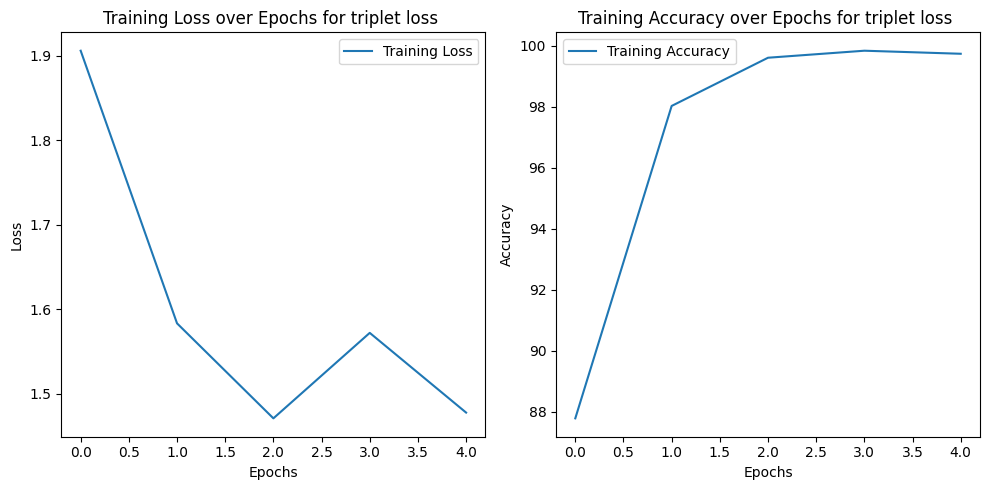

In [43]:
# Visualize loss and accuracy on Training Set for triplet loss
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs for triplet loss ')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs for triplet loss ')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
### Set the model to evaluation mode
resnet_triplet_loss_cross_entropy.eval()
### calculate the number of correct samples
correct = 0
for data in testloader:
    a = resnet_triplet_loss_cross_entropy(data[0].to(device))
    if (a > 0.5 and int(data[1])  == 1) or (a < 0.5 and int(data[1])  == 0) :
        correct+= 1

### Calculate the accuracy on Test set

accuracy = correct / len(testloader)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 0.96%
